In [0]:
#!rm -rf emoji-data
#!rm -rf drive/My\ Drive/Colab\ Notebooks/output/*

In [74]:
!git clone https://github.com/iamcal/emoji-data.git

fatal: destination path 'emoji-data' already exists and is not an empty directory.


In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from google.colab import drive, files
from pprint import pprint
from PIL import Image
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

import sys
import numpy as np
import json
import glob
import random
import os

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# filter only person emojis without tones
with open('emoji-data/emoji.json') as data_file:
    emojis = json.load(data_file)

#smileys = [e for e in emojis if e["category"] != "Symbols" and e["category"] != "Flags" and e["category"] != "Regional"]
smileys = [e for e in emojis if e["category"] == "Smileys & People"]

# filter None value
smileys = [e for e in smileys if e["name"]]

# filter for those with "face" in the name
smileys = [e for e in smileys if ("FACE" in e["name"])]

pprint("minimized dictionary: {} left out of {} emojis".format(len(smileys), len(emojis)))
# pprint(smileys[0])

'minimized dictionary: 104 left out of 1643 emojis'


In [0]:
paths = [
    "emoji-data/img-apple-64",
    "emoji-data/img-emojione-64",
    "emoji-data/img-facebook-64",
    "emoji-data/img-google-64",
    "emoji-data/img-messenger-64",
    "emoji-data/img-twitter-64"
]
filenames = [s["image"] for s in smileys]
filepaths = []
for p in paths:
    image_paths = glob.glob(p + "/*.png")
    filtered = [p for p in image_paths if p.split("/")[-1] in filenames]
    filepaths = filepaths + filtered
# filepaths

## Convert images to Numpy array

In [0]:
def load_image( infilename ) :
    png = Image.open( infilename )
    png.load()
    # Change transparent pixel to white
    background = Image.new("RGB", png.size, (255, 255, 255))

    # Strip the transparent channel
    # Now the image has only 3 channels
    background.paste(png, mask=png.getchannel('A'))
    # Convert to numpy array
    background = np.asarray( background, dtype="int16" )
    
    return background

In [80]:
data = np.empty((0, 64, 64, 3), int)
for file in filepaths:
  img = load_image(file)
  data = np.append(data, [img], axis=0)

print(data.shape)

(464, 64, 64, 3)


In [0]:
plt.imshow(data[random.randint(0, data.shape[0] - 1)], interpolation='nearest')
plt.show()
# fig, axs = plt.subplots(r, c)
# r = 58
# c = 8
# for i in range(r):
#     for j in range(c):
#         axs[i,j].imshow(data[i * c + j])
#         axs[i,j].axis('off')

# fig.savefig('foo1.png', dpi=1200)
# plt.close()

In [0]:
files.download('foo1.png')

In [0]:

# Ramdomly print an image
# plt.imshow(data[random.randint(0, data.shape[0] - 1)], interpolation='nearest')
# plt.show()

In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(Adam(0.0002, 0.5), loss='binary_crossentropy')

    def build_generator(self):

        model = Sequential()
        model.name="Generator"

        model.add(Dense(512 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 512)))

        model.add(Conv2DTranspose(128, 5, strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, 5, strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(self.channels, kernel_size=5, strides=(2, 2), padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        model.name="Discriminator"

        model.add(Conv2D(64, kernel_size=5, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = data

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Store training losses here
        losses = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Store the losses
            losses.append((d_loss[0], g_loss))

            # Plot the progress
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        return losses

    def save_imgs(self, epoch):
        if epoch is 0:
          return
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs = (gen_imgs + 1) * 127.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:].astype(int))
                axs[i,j].axis('off')
                cnt += 1
        
        fig.savefig('/content/drive/My Drive/Colab Notebooks/All output/output3/{}.png'.format(epoch))
        plt.close()

In [85]:
if __name__ == '__main__':
    dcgan = DCGAN()
    losses = dcgan.train(epochs=10000, batch_size=32, save_interval=100)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0   

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.833593, acc.: 43.75%] [G loss: 0.848673]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.350763, acc.: 84.38%] [G loss: 2.781069]
200 [D loss: 0.214559, acc.: 93.75%] [G loss: 3.439115]
300 [D loss: 0.111438, acc.: 98.44%] [G loss: 3.218821]
400 [D loss: 0.185402, acc.: 93.75%] [G loss: 3.188602]
500 [D loss: 0.232861, acc.: 96.88%] [G loss: 3.672891]
600 [D loss: 0.256374, acc.: 89.06%] [G loss: 3.726957]
700 [D loss: 0.254718, acc.: 89.06%] [G loss: 3.783978]
800 [D loss: 0.318482, acc.: 84.38%] [G loss: 2.966383]
900 [D loss: 0.284902, acc.: 90.62%] [G loss: 3.038284]
1000 [D loss: 0.165905, acc.: 92.19%] [G loss: 4.110415]
1100 [D loss: 0.332452, acc.: 89.06%] [G loss: 3.236193]
1200 [D loss: 0.307154, acc.: 82.81%] [G loss: 2.829900]
1300 [D loss: 0.212903, acc.: 93.75%] [G loss: 4.407164]
1400 [D loss: 0.196748, acc.: 92.19%] [G loss: 4.132071]
1500 [D loss: 0.125082, acc.: 98.44%] [G loss: 3.548328]
1600 [D loss: 0.104017, acc.: 100.00%] [G loss: 3.561304]
1700 [D loss: 0.256472, acc.: 92.19%] [G loss: 4.351307]
1800 [D loss: 0.535847, acc.: 73.44%] [

## Smooth Losses Graph

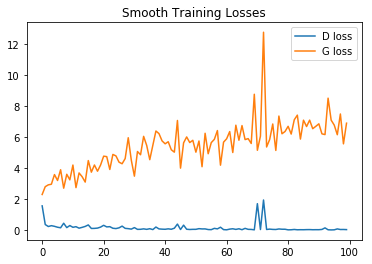

In [86]:
np_losses = np.asarray(losses)
smooth_d_loss = np.linspace(0, np_losses.T[0].shape[0], 100)
smooth_g_loss = np.linspace(0, np_losses.T[1].shape[0], 100)
spl_d = make_interp_spline(list(range(1, np_losses.T[0].shape[0] + 1)), np_losses.T[0], k=3) #BSpline object
spl_g = make_interp_spline(list(range(1, np_losses.T[1].shape[0] + 1)), np_losses.T[1], k=3) 
power_smooth_d = spl_d(smooth_d_loss)
power_smooth_g = spl_g(smooth_g_loss)
plt.plot(power_smooth_d, label='D loss')
plt.plot(power_smooth_g, label='G loss')
plt.title("Smooth Training Losses")
plt.legend()
plt.show()

## Actual Losses Graph

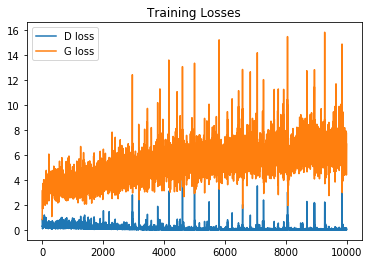

In [87]:
np_losses = np.asarray(losses)
plt.plot(np_losses.T[0], label='D loss')
plt.plot(np_losses.T[1], label='G loss')
plt.title("Training Losses")
plt.legend()
plt.show()